In [1]:
%load_ext autoreload
%matplotlib widget
%autoreload 2
from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)
from time import time_ns
from amftrack.util.dbx import upload_folders, load_dbx, download, get_dropbox_folders
from datetime import datetime
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_full_image_with_features,
)
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    load_graphs,
)
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    plot_edge_width,
    reconstruct_image_from_general,
    plot_full,
)
from amftrack.pipeline.functions.image_processing.extract_width_fun import (
    get_width_info,
    get_width_info_new,
)

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2022-12-14 08:54:40.452113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 08:54:40.986317: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/home2/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/cv2/../../lib64:
2022-12-14 08:54:40.986375: I tensorflow/stream_executor/cuda/cudart_stub.cc:29

In [2]:
plates = [
    "1014_20220525",
    "1023_20220502",
    "102_20201226",
    "1042_20220523",
    "1045_20220504",
    "1048_20220506",
    "1053_20220413",
    "1076_20220511",
    "127_20220705",
    "130_20220707",
    "152_20201224",
    "30_20220509",
]

In [3]:
directory_targ = directory_project

In [4]:
update_analysis_info(directory_targ)
analysis_info = get_analysis_info(directory_targ)
analysis_folders = analysis_info.loc[analysis_info["unique_id"].isin(plates)]

In [4]:
update_plate_info(directory_targ, local=True)
all_folders = get_current_folders(directory_targ, local=True)

analysed:   0%|          | 0/3380 [00:00<?, ?it/s]

In [5]:
plates = ["1048_20220506"]
folders = all_folders.loc[all_folders["unique_id"].isin(plates)]

In [7]:
analysis_folders = analysis_info.loc[analysis_info["unique_id"].isin(["1048_20220506"])]

In [8]:
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
)

In [9]:
folders = folders.sort_values(by="datetime")


In [10]:
exp = Experiment(directory_targ)
exp.load(folders[:100:40])
exp.dates.sort()

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2022-05-06 23:50:00
2022-05-10 11:53:00
2022-05-13 21:51:00


In [11]:
for t in range(exp.ts):
    exp.load_tile_information(t)

load_graphs(exp, directory_targ, post_process=True)

In [16]:
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Edge,
    Node,
)
import numpy as np

In [27]:
np.min(edge)

Edge(171,177)

In [26]:
edge = list(edges)[0]
# Edge(Node(np.min(edge), exp), Node(np.max(edge), exp), exp)

In [29]:
t = 0
nodes = [node for node in exp.nodes if node.is_in(t)]
edges = {edge for node in nodes for edge in node.edges(t)}
# edges = [Edge(Node(np.min(edge), exp), Node(np.max(edge), exp), exp) for edge in edges]
tot_biovolume = np.sum(
    [np.pi*(edge.width(t)/2)**2 * np.linalg.norm(edge.end.pos(t) - edge.begin.pos(t)) * 1.725 for edge in edges]
)

In [30]:
tot_biovolume

2076344.414763998

In [ ]:
args = {"incr": 100, "i": 0, "rh_only": True}
def get_biovolume_density_in_ring(exp, t, args):
    incr = args["incr"]
    i = args["i"]
    regular_hulls, indexes = get_regular_hulls_area_fixed(exp, range(exp.ts), incr)
    if i + 2 <= len(regular_hulls):
        hull1, hull2 = regular_hulls[i], regular_hulls[i + 1]
        biomass = get_biovolume_in_ring(hull1, hull2, t, exp)
        area = ring_area(hull1, hull2)
        return (f"ring_biovolume_density_incr-{incr}_index-{i}", biomass / area)
    else:
        return (f"ring_biovolume_density_incr-{incr}_index-{i}", None)

In [ ]:
t = 2

plot_edge_width(exp, t, lambda edge: edge.width(t), dilation=20,plot_cmap = True)

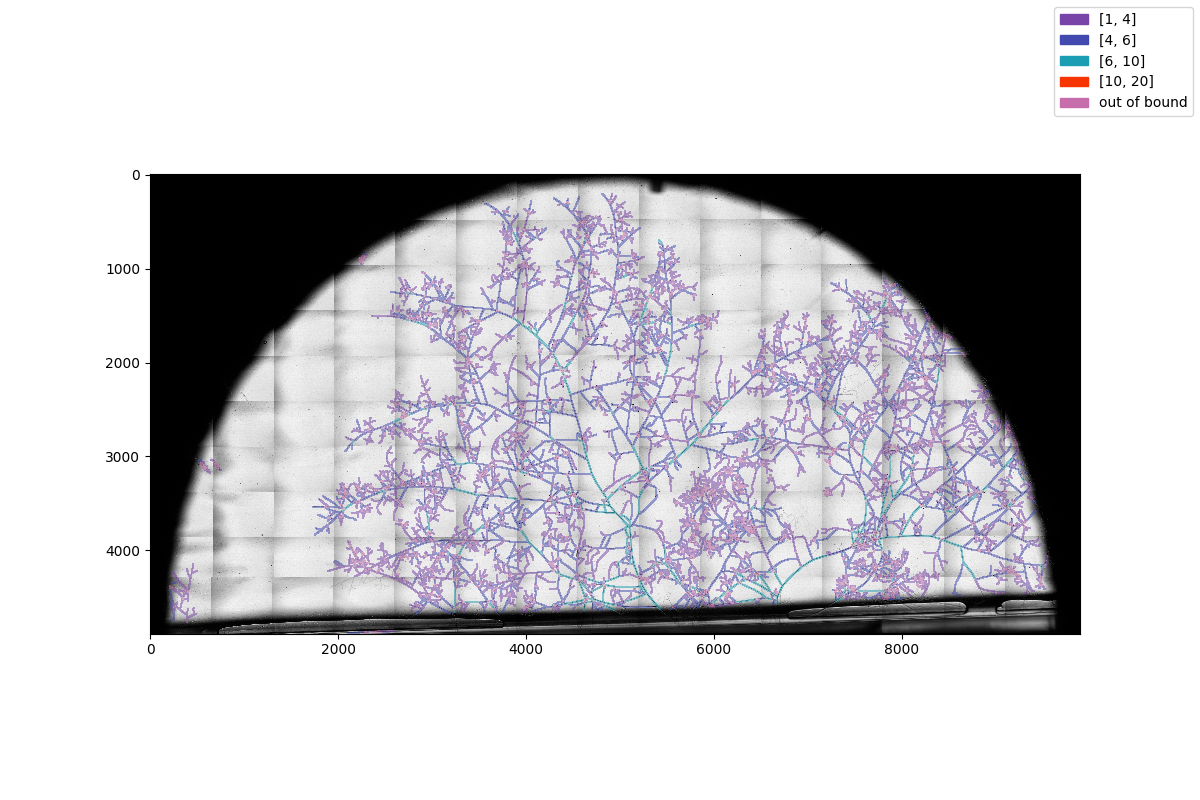

In [13]:
t = 2
plot_edge_width(exp, t, lambda edge: edge.width(t), dilation=20)

In [14]:
import networkx as nx
resolution = 50
skip = False
for t in range(exp.ts)[:2]:
    (G, pos) = exp.nx_graph[t], exp.positions[t]
    edge_test = get_width_info_new(exp,t, resolution=resolution, skip=skip)
    nx.set_edge_attributes(G, edge_test, "width")
    exp.nx_graph[t] = G

True
True


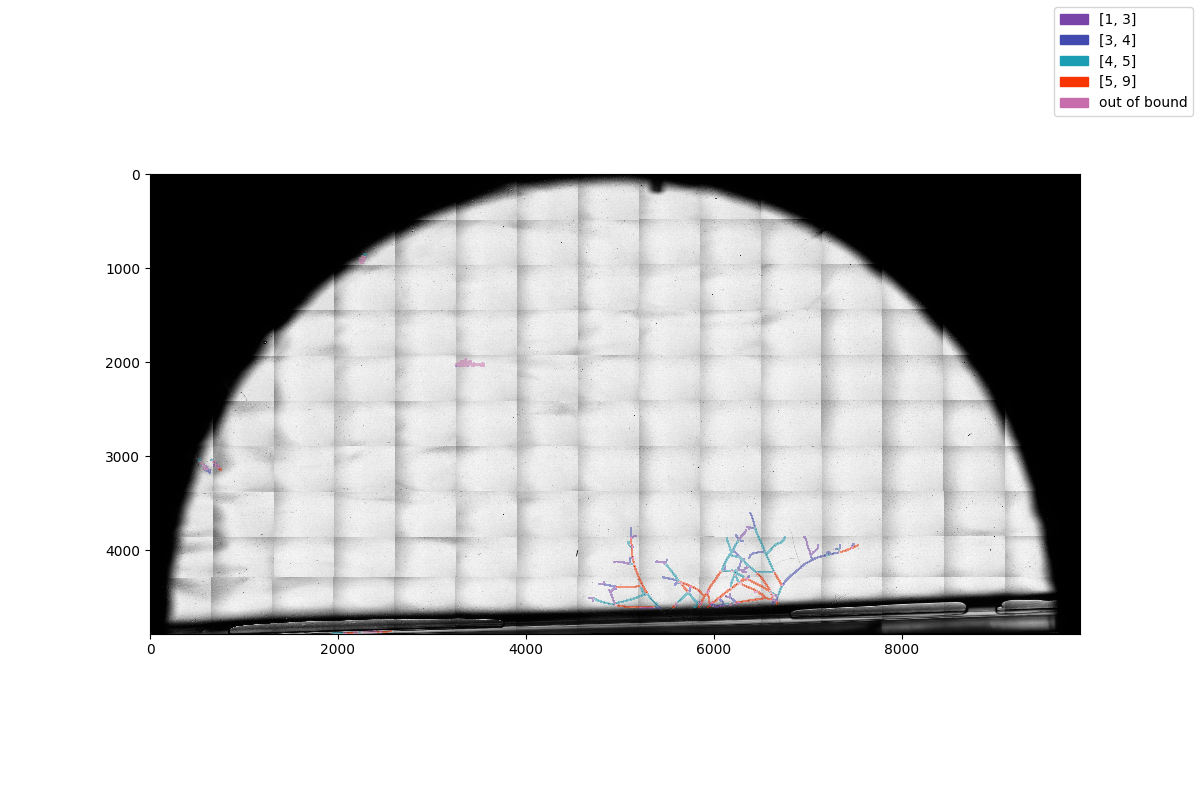

In [26]:
t = 0
intervals=[[1, 3], [3, 4], [4, 5], [5,9]]

plot_edge_width(exp, t, lambda edge: edge.width(t), dilation=20,intervals= intervals)